<a href="https://colab.research.google.com/github/BazaiHassan/tesnorflow-DeepLearning/blob/main/multiclass_classification_tf_cnn01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Dataset and prepare it

In [16]:
import zipfile

# Download the dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip","r")

zip_ref.extractall()
zip_ref.close()

--2023-11-10 18:19:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  28.6MB/s    in 18s     

2023-11-10 18:19:43 (27.5 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [17]:
import os

# Walk through all classes
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"Directories: {dirnames}, Images: {len(filenames)}, Path: {dirpath}")

Directories: ['test', 'train'], Images: 0, Path: 10_food_classes_all_data
Directories: ['chicken_wings', 'ice_cream', 'hamburger', 'steak', 'fried_rice', 'pizza', 'ramen', 'sushi', 'chicken_curry', 'grilled_salmon'], Images: 0, Path: 10_food_classes_all_data/test
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/chicken_wings
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/ice_cream
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/hamburger
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/steak
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/fried_rice
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/pizza
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/ramen
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/sushi
Directories: [], Images: 250, Path: 10_food_classes_all_data/test/chicken_curry
Directories: [], Images: 250, Path: 10_food_classes_all_dat

In [18]:
# Setup train and test directory
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test"

In [19]:
# Class names by getting sub-dirs
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [20]:
# Lets visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(target_dir, target_class):
  # Setup the target directory
  target_folder = target_dir + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print("Random Image:",random_image)

  # Read and plot the image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  print("Image Directory:",target_folder)
  plt.imshow(img)
  plt.title(target_class)

  print(f"Image Shape =  {img.shape}")

  return

Random Image: ['534488.jpg']
Image Directory: 10_food_classes_all_data/train/fried_rice
Image Shape =  (509, 512, 3)


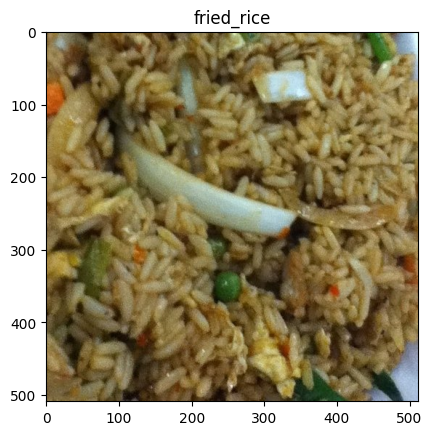

In [21]:
# Visualize
img = view_random_images(train_dir,random.choice(class_names))

# 2. Preprocess the data

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)



Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [27]:
# Now lets use data augmentation to reduce overfitting and make our model smarter
train_datagen_augmented = ImageDataGenerator(
    rescale=1/255., # rotate the image slightly between 0 and 20 degrees
    rotation_range = 0.2,  # shear the image
    shear_range=0.2, # zoom into the image
    zoom_range=0.2, # shift the image width ways
    width_shift_range=0.2, # shift the image height ways
    height_shift_range=0.3, # flip the image on the horizontal axis
    horizontal_flip = True
)

In [29]:
train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode="categorical",
    shuffle=True
)

Found 7500 images belonging to 10 classes.


# 3. Create CNN model

In [30]:
# Let's use Tinny VGG algorithm
'''
https://poloclub.github.io/cnn-explainer/
'''
import tensorflow as tf
tvgg_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
]
)

# Compile the model
tvgg_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 4. Fit the model (Run the model)

In [31]:
# Fit the model
history_tvvg_model = tvgg_model.fit(
    train_data_augmented,
    epochs=5,
    steps_per_epoch=len(train_data_augmented),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
235/235 [==============================] - 105s 440ms/step - loss: 2.2211 - accuracy: 0.1699 - val_loss: 2.0577 - val_accuracy: 0.2436
Epoch 2/5
235/235 [==============================] - 103s 440ms/step - loss: 2.1219 - accuracy: 0.2299 - val_loss: 1.9850 - val_accuracy: 0.3036
Epoch 3/5
235/235 [==============================] - 107s 456ms/step - loss: 2.0679 - accuracy: 0.2588 - val_loss: 1.9144 - val_accuracy: 0.3192
Epoch 4/5
235/235 [==============================] - 106s 452ms/step - loss: 2.0245 - accuracy: 0.2841 - val_loss: 1.9262 - val_accuracy: 0.3364
Epoch 5/5
235/235 [==============================] - 105s 447ms/step - loss: 2.0261 - accuracy: 0.2896 - val_loss: 1.8632 - val_accuracy: 0.3760


# 5. Post-processing

In [32]:
# Plotting separate curves
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["val_accuracy"]))

  # Plot Loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

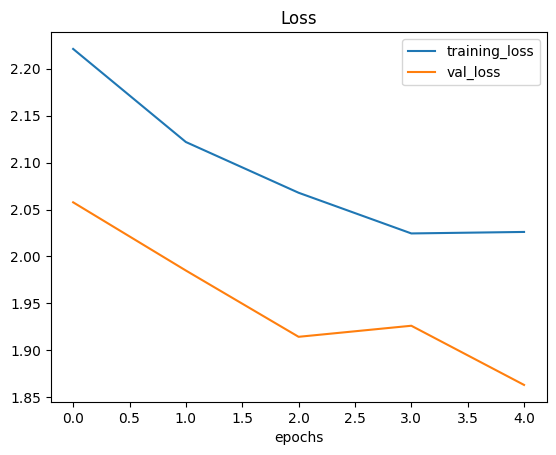

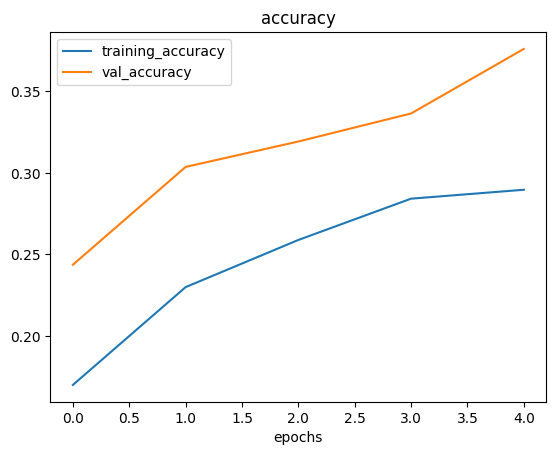

In [33]:
plot_loss_curves(history_tvvg_model)

In [34]:
# Evaluate the model

tvgg_model.evaluate(test_data)

79/79 [==============================] - 7s 90ms/step - loss: 1.8632 - accuracy: 0.3760


[1.8631765842437744, 0.37599998712539673]

# 6. Make some predictions

In [37]:
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [44]:
def load_prep_image(filename, img_shape=224):
  # Read file
  img = tf.io.read_file(filename)

  # Decode the read data into a tensor
  img = tf.image.decode_image(img)

  # Re-size the images
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale
  img = img/255.

  return img


def predict_plot(model, filename, class_names=class_names):

  img = load_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0])>1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]

  print(f"The predicted image is :: {pred_class}")
  plt.imshow(img)
  plt.title(f"{pred_class}")

In [49]:
!wget https://www.wholesomeyum.com/wp-content/uploads/2021/06/wholesomeyum-Grilled-Salmon-Recipe-8.jpg

--2023-11-10 18:50:18--  https://www.wholesomeyum.com/wp-content/uploads/2021/06/wholesomeyum-Grilled-Salmon-Recipe-8.jpg
Resolving www.wholesomeyum.com (www.wholesomeyum.com)... 104.26.3.91, 172.67.72.16, 104.26.2.91
Connecting to www.wholesomeyum.com (www.wholesomeyum.com)|104.26.3.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170966 (167K) [image/jpeg]
Saving to: ‘wholesomeyum-Grilled-Salmon-Recipe-8.jpg’

wholesomeyum-Grille 100%[===================>] 166.96K  --.-KB/s    in 0.05s   

2023-11-10 18:50:18 (3.39 MB/s) - ‘wholesomeyum-Grilled-Salmon-Recipe-8.jpg’ saved [170966/170966]



1/1 [==============================] - 0s 47ms/step
The predicted image is :: fried_rice


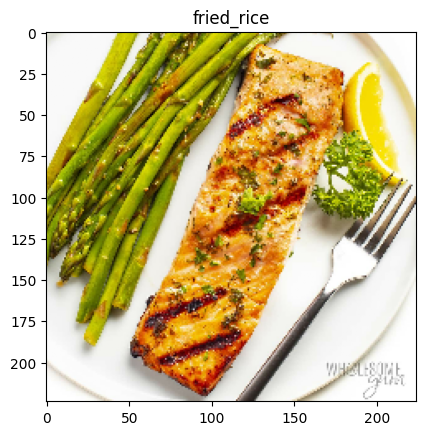

In [50]:
predict_plot(tvgg_model, "wholesomeyum-Grilled-Salmon-Recipe-8.jpg")

In [47]:
!wget https://www.whiskaffair.com/wp-content/uploads/2021/10/Andhra-Chicken-Curry-2-3.jpg

--2023-11-10 18:48:58--  https://www.whiskaffair.com/wp-content/uploads/2021/10/Andhra-Chicken-Curry-2-3.jpg
Resolving www.whiskaffair.com (www.whiskaffair.com)... 172.67.191.3, 104.21.89.185
Connecting to www.whiskaffair.com (www.whiskaffair.com)|172.67.191.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103941 (102K) [image/jpeg]
Saving to: ‘Andhra-Chicken-Curry-2-3.jpg’

Andhra-Chicken-Curr 100%[===================>] 101.50K  --.-KB/s    in 0.05s   

2023-11-10 18:48:59 (1.85 MB/s) - ‘Andhra-Chicken-Curry-2-3.jpg’ saved [103941/103941]



1/1 [==============================] - 0s 20ms/step
The predicted image is :: chicken_curry


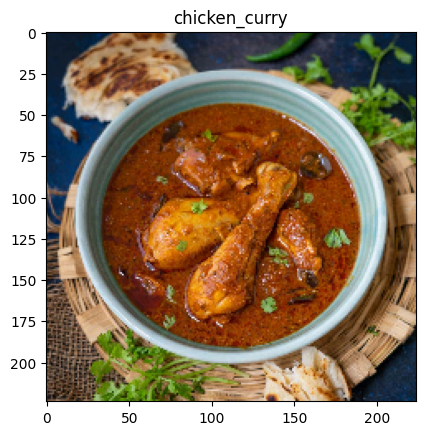

In [48]:
predict_plot(tvgg_model, "Andhra-Chicken-Curry-2-3.jpg")

The model works but it can be better by working on it.